# Proyek Klasifikasi Gambar: Indonesian Food
- **Nama:** M. Sulthon Sayid Abdurrohman
- **Email:** sltnasyd44@gmail.com   
- **ID Dicoding:** sulthonsayid

## Import Semua Packages/Library yang Digunakan

In [1]:
import numpy as np
import pandas as pd

import os
import shutil
from shutil import copyfile

from PIL import Image
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
# import tensorflowjs as tfjs
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau



from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

## Data Preparation

### Data Loading

In [2]:
os.listdir('./')

['.git',
 '.gitattributes',
 'Dataset-Final',
 'Indonesian-Food-Dataset',
 'model.h5',
 'notebook.ipynb',
 'README.md',
 'requirements.txt',
 'saved_model',
 'tfjs_model',
 'tflite']

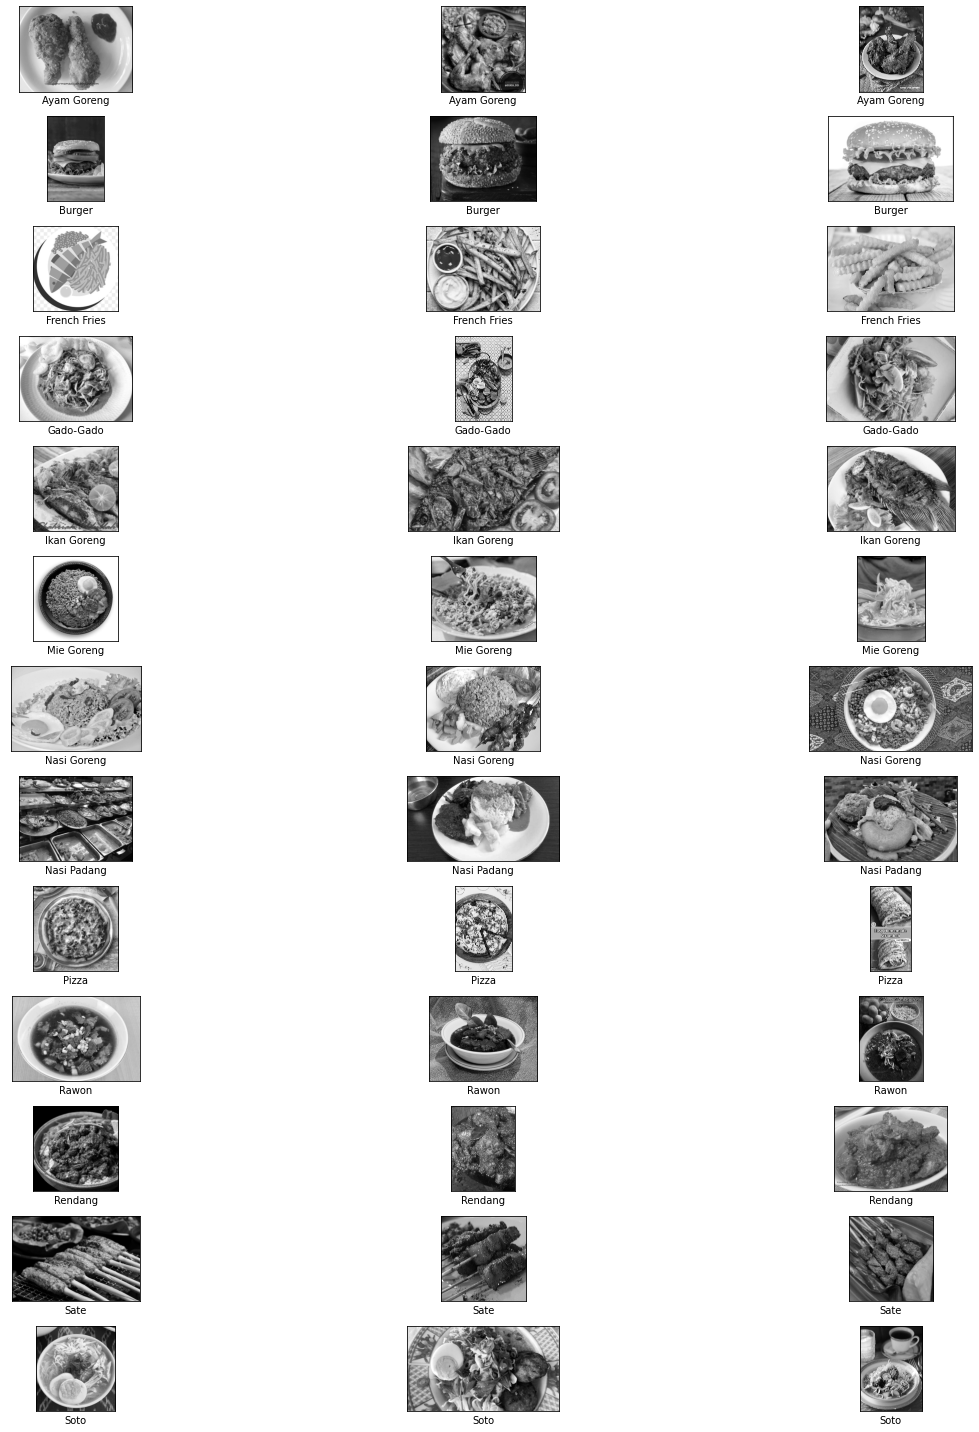

In [3]:
imgs = {}

# Tentukan path sumber train
path = "./Indonesian-Food-Dataset"
path_sub = os.path.join(path, "dataset_gambar")
for i in os.listdir(path_sub):
    imgs[i] = os.listdir(os.path.join(path_sub, i))

fig, axs = plt.subplots(len(imgs.keys()), 3, figsize=(20, 20))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(imgs[class_name], 3, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L") 
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

In [4]:
def print_images_resolution(directory):
    unique_sizes = set()  # To track unique image sizes across all subdirectories
    total_images = 0

    # Loop through all subdirectories
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        
        # Only process subdirectories (skip files)
        if os.path.isdir(subdir_path):
            image_files = os.listdir(subdir_path)
            num_images = len(image_files)
            print(f"{subdir}: {num_images} images")
            total_images += num_images

            # Process each image in the subdirectory
            for img_file in image_files:
                img_path = os.path.join(subdir_path, img_file)
                
                # Check if it's an image file (you could improve by filtering for image extensions)
                try:
                    with Image.open(img_path) as img:
                        unique_sizes.add(img.size)
                except Exception as e:
                    print(f"Error opening image {img_path}: {e}")

    # Print the unique sizes
    print("\nUnique image sizes:")
    for size in unique_sizes:
        print(f"- {size}")
    
    print("---------------")
    print(f"\nTotal images across all subdirectories: {total_images}")

# Example usage:
directory = "./Indonesian-Food-Dataset/dataset_gambar"
print_images_resolution(directory)

Ayam Goreng: 500 images
Burger: 500 images
French Fries: 500 images
Gado-Gado: 500 images
Ikan Goreng: 500 images
Mie Goreng: 500 images
Nasi Goreng: 500 images
Nasi Padang: 500 images
Pizza: 500 images
Rawon: 500 images
Rendang: 500 images
Sate: 500 images
Soto: 500 images

Unique image sizes:
- (1977, 1112)
- (1200, 1600)
- (1600, 1311)
- (790, 682)
- (360, 540)
- (1600, 902)
- (800, 583)
- (1217, 1280)
- (1440, 800)
- (1600, 1167)
- (930, 549)
- (640, 859)
- (613, 613)
- (640, 450)
- (900, 1200)
- (550, 413)
- (342, 155)
- (1223, 807)
- (200, 300)
- (4096, 2731)
- (1200, 674)
- (1200, 1577)
- (1600, 1059)
- (1920, 1229)
- (1000, 1143)
- (768, 528)
- (1395, 1035)
- (1500, 1200)
- (1393, 845)
- (2015, 1008)
- (600, 800)
- (1000, 999)
- (1000, 770)
- (6720, 4480)
- (940, 576)
- (1920, 1350)
- (4000, 3000)
- (1080, 735)
- (1000, 626)
- (1440, 1801)
- (1024, 574)
- (2880, 1922)
- (1348, 1080)
- (970, 1277)
- (2008, 1355)
- (2000, 1500)
- (300, 516)
- (830, 565)
- (1000, 747)
- (500, 281)

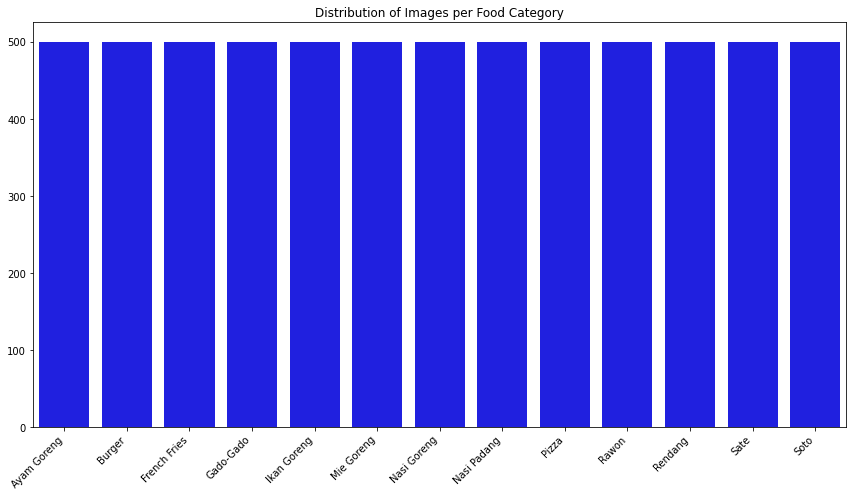

In [5]:
mypath = './Indonesian-Food-Dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/dataset_gambar\\')[-1])
        file_name.append(name)

# Create the DataFrame
df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Count the number of images for each label
label_counts = df.groupby('labels').size().reset_index(name='count')

# Plot the distribution of images per label using Seaborn with blue color
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='labels', y='count', data=label_counts, color='blue')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the labels and title
plt.xlabel(None)
plt.ylabel(None)
plt.title('Distribution of Images per Food Category')

# Show the plot
plt.tight_layout()
plt.show()

### Data Preprocessing

#### Split Dataset

In [2]:
TRAIN_DIR = "./Indonesian-Food-Dataset/dataset_gambar"

image_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [3]:
train_generator = image_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(100, 100),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (100, 100),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

Found 5196 images belonging to 13 classes.
Found 1295 images belonging to 13 classes.


## Modelling

In [10]:
model = Sequential()

# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# 4th Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# 5th Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Flatten layer to feed the features into Dense layers
model.add(Flatten())

# 1st Dense Layer
model.add(Dense(128, activation='relu'))

# 1st Dropout Layer
model.add(Dropout(0.5))

# 2nd Dense Layer
model.add(Dense(64, activation='relu'))

# 2nd Dropout Layer
model.add(Dropout(0.3))

# Final Dense layer for output prediction (13 classes)
# Use 'softmax' activation for multi-class classification
model.add(Dense(13, activation='softmax'))

######################### Compile Model ################################
# Use categorical_crossentropy for multi-class classification
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',  # Correct loss for multi-class classification
              metrics=['accuracy'])

# Summary of the Model Architecture
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 batch_normalization_2 (Bat  (None, 100, 100, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        16416     
                                                                 
 batch_normalization_3 (Bat  (None, 50, 50, 32)        128       
 chNormalization)                                                
                                                      

In [5]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs.get('val_accuracy') >= 0.87:
            print('\n# This callback stop the training  at :', '\nEpoch :', epoch, ' Val_Accuracy :%2.2f%%' %(logs['val_accuracy']*100))
            self.model.stop_training = True

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=47,
    epochs=500,
    validation_data=validation_generator,
    validation_steps=10,
    verbose=1,
    callbacks=[EarlyStopping()]
)

Epoch 1/500
47/47 [==============================] - 76s 2s/step - loss: 0.5761 - accuracy: 0.8139 - val_loss: 1.2268 - val_accuracy: 0.7047
Epoch 2/500
47/47 [==============================] - 58s 1s/step - loss: 0.5725 - accuracy: 0.8204 - val_loss: 1.0829 - val_accuracy: 0.6969
Epoch 3/500
47/47 [==============================] - 51s 1s/step - loss: 0.5509 - accuracy: 0.8244 - val_loss: 1.2386 - val_accuracy: 0.6828
Epoch 4/500
47/47 [==============================] - 47s 1s/step - loss: 0.5665 - accuracy: 0.8156 - val_loss: 1.0361 - val_accuracy: 0.7531
Epoch 5/500
47/47 [==============================] - 46s 988ms/step - loss: 0.6107 - accuracy: 0.8062 - val_loss: 1.1837 - val_accuracy: 0.6453
Epoch 6/500
47/47 [==============================] - 47s 999ms/step - loss: 0.5578 - accuracy: 0.8271 - val_loss: 0.7754 - val_accuracy: 0.7453
Epoch 7/500
47/47 [==============================] - 45s 963ms/step - loss: 0.5393 - accuracy: 0.8261 - val_loss: 1.2195 - val_accuracy: 0.6750
Epoc

## Evaluasi dan Visualisasi

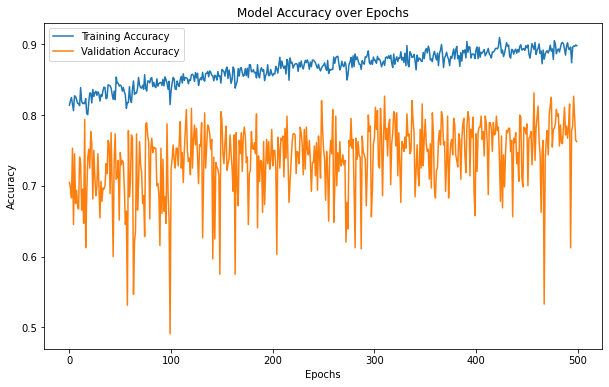

In [14]:
# Plotting the Accuracy Graph
plt.figure(figsize=(10, 6))

# Training accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')

# Validation accuracy plot
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Adding labels and title
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Displaying the legend
plt.legend()

# Display the plot
plt.show()

## Konversi Model

In [18]:
model.save("model.h5")

In [47]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-01-01 19:51:08.043260: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

Traceback (most recent call last):
  File "C:\Users\sltna\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\sltna\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\sltna\AppData\Local\Programs\Python\Python310\Scripts\tensorflowjs_converter.exe\__main__.py", line 4, in <module>
  File "C:\Users\sltna\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflowjs\__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "C:\Users\sltna\AppData\Local\Programs\Python\Python310\lib\site-packages\te

In [20]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [21]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [24]:
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

832052

## Inference (Optional)